In [1]:
import numpy as np
from TDD.TDD import Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit
import cProfile

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\__init__.py:64: RuntimeWarning: Could not import the Aer provider from the qiskit-aer package. Install qiskit-aer or check your installation.
  RuntimeWarning)


In [2]:
def simulate(cir,ini=False):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
    
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)

#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

In [3]:
def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd1,tdd)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    tdd_new=renormalize(tdd_new)
    return tdd_new

def eliminate_global_map(tdd):
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    the_map = tdd.map
    while the_map.level>-1:
        q = int(tdd.key_2_index[the_map.level][1:])
        if tdd.key_2_index[the_map.level][0]=='x':
            if the_map.rotate>0:
                cir_head.u1(np.pi/4*(8-the_map.rotate),q)
            if the_map.x==1:
                cir_head.x(q)
        else:
            if the_map.x==1:
                cir_end.x(q)
            if the_map.rotate>0:
                cir_end.u1(np.pi/4*(8-the_map.rotate),q)
        the_map=the_map.father
    
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    return tdd_new,cir_head,cir_end

def eliminate_control(tdd,x,the_map):
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    q_c = int(tdd.key_2_index[x][1:])
    
    while the_map.level>-1:
        if x%2!=the_map.level%2:
            the_map=the_map.father
            continue
        q = int(tdd.key_2_index[the_map.level][1:])
#         print(q_c,q)

        if tdd.key_2_index[the_map.level][0]=='x':
            if the_map.x==1:
                cir_head.cx(q_c,q)
            if the_map.rotate>0:
                cir_head.cu1(np.pi/4*(8-the_map.rotate),q_c,q)
        else:
            if the_map.x==1:
                cir_end.cx(q_c,q)
            if the_map.rotate>0:
                cir_end.cu1(np.pi/4*(8-the_map.rotate),q_c,q)
        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    return tdd_new,cir_head,cir_end

    

def eliminate_top_level(tdd):
    
    the_map1 = tdd.node.out_maps[1]
    tdd_new,cir_head,cir_end = eliminate_control(tdd,tdd.node.key,the_map1)
    
    the_map2 = tdd.node.successor[0].out_maps[1]
    tdd_new2,cir_head2,cir_end2 = eliminate_control(tdd_new,tdd.node.successor[0].key,the_map2)
    
    
#     if tdd.node.successor[0]!=tdd.node.successor[1]:
#         print('Still split 0')
        
#     if tdd.node.successor[0].successor[0]!=tdd.node.successor[0].successor[1]:
#         print('Still split 1')
        
#     the_map1 = tdd_new2.node.out_maps[1]
#     the_map2 = tdd_new2.node.successor[0].out_maps[1]
    
#     if the_map1.level=tdd_new2.node.key-1:
#         the_map1=the_map1.father
        
#     if the_map1.level>-1 and the_map2.level>-1:
    
    
    return tdd_new2,cir_head2+cir_head,cir_end+cir_end2
    
def syn(tdd):
    tdd_new,cir_head,cir_end=eliminate_global_map(tdd)
    tdd_new2,cir_head2,cir_end2=eliminate_top_level(tdd_new)
    return tdd_new2,cir_head2+cir_head,cir_end+cir_end2

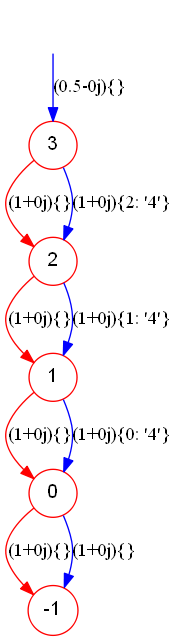

In [33]:
n=2
m=10
cir=gen_cir('Random_Clifford',n,m)
tdd=simulate(cir,True)
# tdd.show(False)
tdd_new,cir_head,cir_end=syn(tdd)
tdd_new.show(False)
# cir_end.draw()

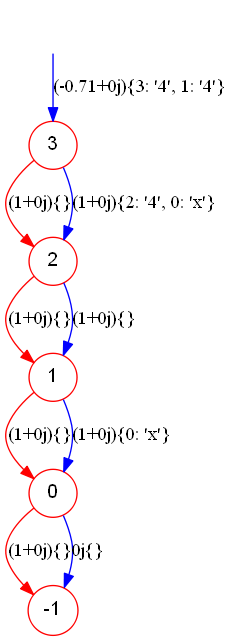

In [32]:
# tdd_new,cir_head,cir_end=syn(tdd_new)
cir_head=QuantumCircuit(2)
cir_end=QuantumCircuit(2)
# cir_head.cz(1,0)
# cir_end.cz(1,0)
cir_end.z(1)
tdd_new2=update_tdd(tdd_new,cir_head,cir_end)
tdd_new2.show(False)

In [6]:
# with open('test_q2_cl.qasm','w') as f:
#     f.write(cir.qasm())
# cir.draw()

In [10]:
cir.draw()
cir2=cir_head+cir+cir_end
cir2.draw()

┌─────────┐ ┌───┐┌───┐               ┌───┐┌───┐┌───────┐
q_0: ─■──┤ U1(π/2) ├─┤ S ├┤ S ├──■────────────┤ X ├┤ H ├┤ U1(π) ├
      │π ├─────────┴┐├───┤└───┘┌─┴─┐┌───┐┌───┐└─┬─┘├───┤└─┬───┬─┘
q_1: ─■──┤ U1(3π/2) ├┤ X ├─────┤ X ├┤ S ├┤ Z ├──■──┤ Y ├──┤ Z ├──
         └──────────┘└───┘     └───┘└───┘└───┘     └───┘  └───┘

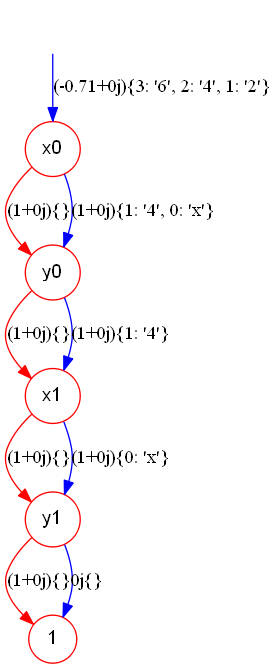

In [7]:
cir = QuantumCircuit.from_qasm_file("test_q2_cl.qasm")
tdd=simulate(cir,True)
tdd=renormalize(tdd)
tdd.show()
# cir.draw()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.


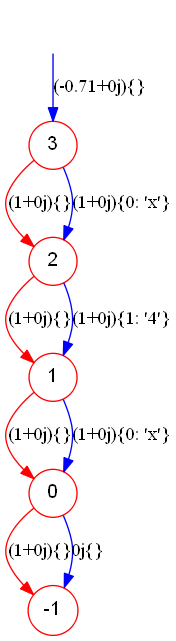

In [8]:
tdd_new,cir_head,cir_end=syn(tdd)
tdd_new.show(False)
# cir_end.draw()

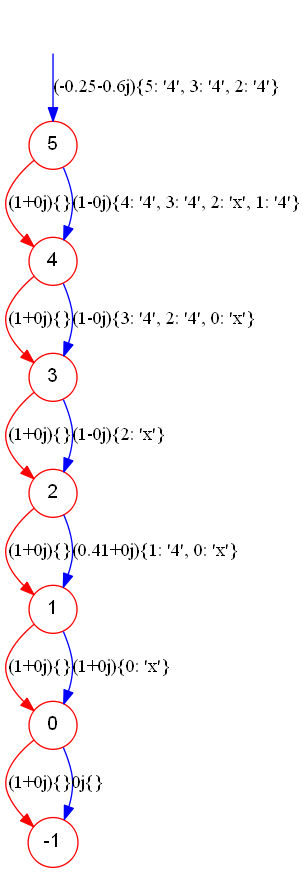

In [19]:
cir_head=QuantumCircuit(3)
cir_end=QuantumCircuit(3)
cir_end.cx(2,0)
tdd_new2=update_tdd(tdd_new,cir_head,cir_end)
tdd_new2.show(False)

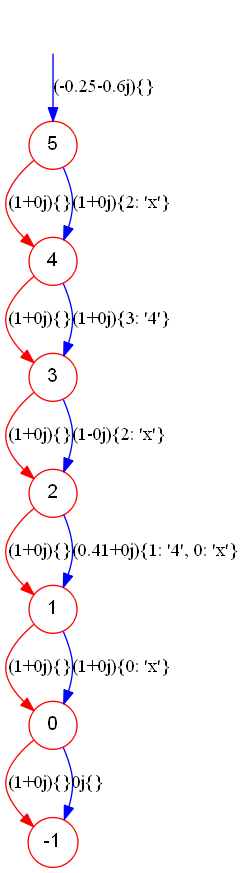

In [20]:
tdd_new3,cir_head,cir_end=syn(tdd_new2)
tdd_new3.show(False)
# cir_end.draw()

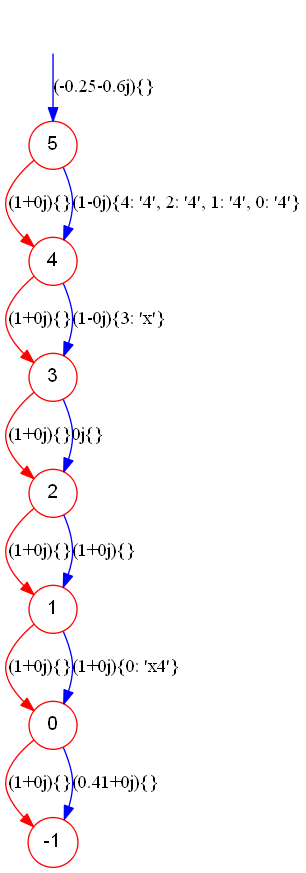

In [21]:
cir_head=QuantumCircuit(3)
# cir_head.cz(1,0)
cir_head.h(0)
cir_end=QuantumCircuit(3)
cir_end.h(0)
# cir_end.cz(1,0)
tdd_new4=update_tdd(tdd_new3,cir_head,cir_end)
tdd_new4.show(False)

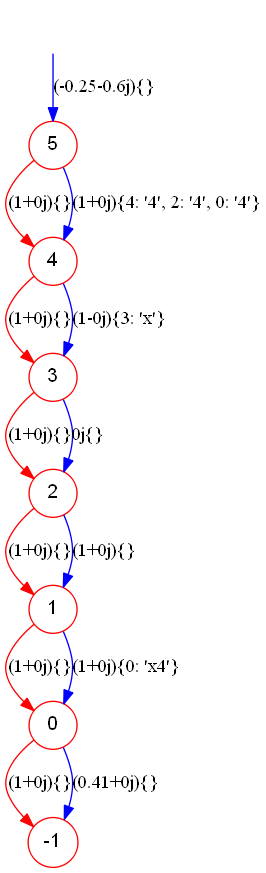

In [22]:
tdd_new5,cir_head,cir_end=syn(tdd_new4)
tdd_new5.show(False)